# Relational Databases in Practice

## From Theory to Tables

The previous chapter introduced relational theory's mathematical foundations: relations as sets of tuples, functional dependencies, and the formal operations of relational algebra. While this mathematical rigor provides the theoretical foundation for database systems, most practitioners don't design databases by analyzing functional dependencies or proving normal form properties.

Instead, they use the **Entity-Relationship Model (ERM)**, a practical design methodology that maps domain concepts—the entities and relationships in your problem space—directly to database structures. This chapter shows how ERM works in practice, demonstrates common database operations, and reveals the limitations that motivate DataJoint's workflow-centric approach.

We'll work through a concrete example: designing a database for a research lab that conducts experiments, collects measurements, and analyzes results. This scenario will illustrate both the power and the limitations of traditional relational databases for scientific workflows.


## A Working Example: Research Lab Database

### The Domain

Consider a neuroscience research lab that studies visual perception. The lab has several researchers who design and conduct experiments. Each experiment involves presenting visual stimuli to animal subjects and recording neural activity. The raw recordings are then analyzed to extract useful information about how neurons respond to different stimuli.

This is a typical scientific workflow with several distinct stages:
1. **Study Design**: Researchers plan experiments
2. **Data Acquisition**: Experiments generate raw recordings
3. **Data Processing**: Raw data is analyzed to extract results
4. **Interpretation**: Results are interpreted in the context of research questions

Let's design a database to support this workflow.


### Identifying Entities

The first step in ERM is identifying the **entities**—the distinct "things" in your domain that have independent existence and need to be tracked.

In our research lab, we can identify several entities:

**Researcher**: People conducting the research
- Attributes: researcher_id (unique identifier), name, email, lab_role

**AnimalSubject**: The experimental subjects
- Attributes: subject_id, species, date_of_birth, sex

**Experiment**: A planned experimental session
- Attributes: experiment_id, experiment_date, description, protocol

**Recording**: Raw data collected during an experiment
- Attributes: recording_id, recording_time, file_path, recording_quality

**NeuralUnit**: Individual neurons identified in recordings
- Attributes: unit_id, spike_rate, receptive_field_size


### Identifying Relationships

Entities don't exist in isolation—they're connected through **relationships** that capture how they interact:

- A **Researcher** *conducts* an **Experiment** (one-to-many: one researcher can conduct multiple experiments)
- An **AnimalSubject** *participates in* an **Experiment** (one-to-many: one subject can participate in multiple experiments)
- An **Experiment** *produces* **Recordings** (one-to-many: one experiment can generate multiple recordings)
- A **Recording** *contains* **NeuralUnits** (one-to-many: one recording can contain many identified neurons)


### Drawing the ER Diagram

We can visualize this structure using Crow's Foot notation:

```mermaid
erDiagram
    RESEARCHER ||--o{ EXPERIMENT : conducts
    ANIMAL_SUBJECT ||--o{ EXPERIMENT : "participates-in"
    EXPERIMENT ||--o{ RECORDING : produces
    RECORDING ||--o{ NEURAL_UNIT : contains
    
    RESEARCHER {
        int researcher_id PK
        string researcher_name
        string email
        string lab_role
    }
    
    ANIMAL_SUBJECT {
        int subject_id PK
        string species
        date date_of_birth
        string sex
    }
    
    EXPERIMENT {
        int experiment_id PK
        int researcher_id FK
        int subject_id FK
        date experiment_date
        string description
        string protocol
    }
    
    RECORDING {
        int experiment_id PK, FK
        int recording_id PK
        datetime recording_time
        string file_path
        string recording_quality
    }
    
    NEURAL_UNIT {
        int experiment_id PK, FK
        int recording_id PK, FK        
        int unit_id PK
        float spike_rate
        float receptive_field_size
    }
```

The diagram shows:
- **Entities** as rectangles containing their attributes
- **Primary keys (PK)**: Unique identifiers for each entity
- **Foreign keys (FK)**: References to related entities
- **Relationships** as lines with symbols indicating cardinality:
  - `||` means "exactly one"
  - `o{` means "zero or many"


### Translating to SQL Tables

The ER diagram translates almost directly to SQL table definitions:


In [ ]:
-- Create all tables for the research lab database

CREATE TABLE Researcher (
    researcher_id INT,
    name VARCHAR(100) NOT NULL,
    email VARCHAR(100) UNIQUE,
    lab_role VARCHAR(50),
    PRIMARY KEY(researcher_id)
);

CREATE TABLE AnimalSubject (
    subject_id INT PRIMARY KEY,
    species VARCHAR(50) NOT NULL,
    date_of_birth DATE,
    sex ENUM('M', 'F', 'Unknown')
);

CREATE TABLE Experiment (
    experiment_id INT,
    researcher_id INT NOT NULL,
    subject_id INT NOT NULL,
    experiment_date DATE NOT NULL,
    description TEXT,
    protocol VARCHAR(100),
    PRIMARY KEY (experiment_id),
    FOREIGN KEY (researcher_id) REFERENCES Researcher(researcher_id),
    FOREIGN KEY (subject_id) REFERENCES AnimalSubject(subject_id)
);

CREATE TABLE Recording (
    experiment_id INT NOT NULL,
    recording_id INT NOT NULL,
    recording_time DATETIME NOT NULL,
    file_path VARCHAR(255) NOT NULL,
    recording_quality ENUM('excellent', 'good', 'fair', 'poor'),
    PRIMARY KEY (experiment_id, recording_id),
    FOREIGN KEY (experiment_id) REFERENCES Experiment(experiment_id)
);

CREATE TABLE NeuralUnit (
    experiment_id INT NOT NULL,
    recording_id INT NOT NULL,
    unit_id INT NOT NULL,
    spike_rate FLOAT NOT NULL,
    receptive_field_size FLOAT NOT NULL,
    PRIMARY KEY (experiment_id, recording_id, unit_id),
    FOREIGN KEY (experiment_id, recording_id) REFERENCES Recording(experiment_id, recording_id)
);


Note the key features:
- **PRIMARY KEY**: Ensures each row has a unique identifier
- **FOREIGN KEY**: Enforces referential integrity—you can't reference a non-existent entity
- **NOT NULL**: Requires certain attributes to have values
- **Data types**: Constrain what values can be stored (INT, VARCHAR, DATE, etc.)


### Populating with Sample Data

Let's add some sample data to see the database in action:


In [ ]:
-- Add researchers
INSERT INTO Researcher (researcher_id, name, email, lab_role) VALUES
    (1, 'Dr. Sarah Chen', 'schen@university.edu', 'Principal Investigator'),
    (2, 'Alex Martinez', 'amartinez@university.edu', 'Postdoc'),
    (3, 'Jamie Park', 'jpark@university.edu', 'Graduate Student');

-- Add animal subjects
INSERT INTO AnimalSubject (subject_id, species, date_of_birth, sex) VALUES
    (1, 'Mouse', '2024-01-15', 'M'),
    (2, 'Mouse', '2024-01-20', 'F'),
    (3, 'Mouse', '2024-02-03', 'M');

-- Add an experiment
INSERT INTO Experiment (experiment_id, researcher_id, subject_id, experiment_date, description, protocol) VALUES
    (1, 2, 1, '2024-08-15', 'Visual cortex recording during grating stimuli', 'Protocol-V1-001');

-- Add recordings from that experiment
INSERT INTO Recording (experiment_id, recording_id, recording_time, file_path, recording_quality) VALUES
    (1, 1, '2024-08-15 10:30:00', '/data/2024/08/15/rec001.dat', 'excellent'),
    (1, 2, '2024-08-15 11:45:00', '/data/2024/08/15/rec002.dat', 'good');

-- Add neural units identified in first recording
INSERT INTO NeuralUnit (experiment_id, recording_id, unit_id, spike_rate, receptive_field_size) VALUES
    (1, 1, 1, 15.3, 2.5),
    (1, 1, 2, 8.7, 3.1),
    (1, 1, 3, 22.4, 1.8);


## Common Database Operations

Now that we have a populated database, let's explore the fundamental operations you'll use daily.


### Querying Data: SELECT

The most common operation is retrieving data. SQL's `SELECT` statement specifies *what* you want, and the database figures out *how* to get it:


In [ ]:
-- Get all researchers
SELECT * FROM Researcher;

-- Get specific attributes
SELECT name, email FROM Researcher WHERE lab_role = 'Graduate Student';

-- Count neural units per recording
SELECT experiment_id, recording_id, COUNT(*) as unit_count 
FROM NeuralUnit 
GROUP BY experiment_id, recording_id;

-- Get average spike rate
SELECT AVG(spike_rate) as mean_rate, STD(spike_rate) as std_rate
FROM NeuralUnit;


### Joining Tables: Combining Related Data

The real power of relational databases emerges when joining related tables:


In [ ]:
-- Which researcher conducted each experiment?
SELECT experiment_id, experiment_date, researcher_name
FROM Experiment JOIN Researcher USING (researcher_id);

-- Full experiment details including subject
SELECT 
    experiment_id,
    experiment_date,
    researcher_name,
    species,
    sex,
    description
FROM Experiment JOIN Researcher USING(researcher_id) JOIN AnimalSubject USING(subject_id);

-- Count recordings per researcher
SELECT 
    research_id, researcher_name,
    COUNT(*) as num_recordings
FROM Researcher JOIN Experiment USING(researcher_id) JOIN Recording USING(experiment_id)
GROUP BY researcher_id, researcher_name;


These joins follow the foreign key relationships defined in our schema, ensuring we only combine data that's meaningfully related.


### Inserting Data: Adding New Records

Adding data follows a hierarchical pattern dictated by foreign keys:


In [ ]:
-- Must add researcher before experiments they conduct
INSERT INTO Researcher (researcher_id, name, email, lab_role) 
VALUES (4, 'Dr. Maria Rodriguez', 'mrodriguez@university.edu', 'Assistant Professor');

-- Must add experiment before its recordings
INSERT INTO Experiment (experiment_id, researcher_id, subject_id, experiment_date, description, protocol)
VALUES (2, 4, 2, '2024-09-20', 'Orientation selectivity experiment', 'Protocol-V1-002');

-- Can only add recording after experiment exists
INSERT INTO Recording (experiment_id, recording_id, recording_time, file_path, recording_quality)
VALUES (2, 1, '2024-09-20 14:00:00', '/data/2024/09/20/rec001.dat', 'excellent');


The foreign key constraints enforce this order—you can't reference entities that don't exist yet.


### Updating Data: Modifying Records

SQL allows modifying existing data, but this is where problems begin for scientific workflows:


In [ ]:
-- Update a researcher's email
UPDATE Researcher 
SET email = 'sarah.chen@university.edu' 
WHERE researcher_id = 1;

-- Update recording quality assessment
UPDATE Recording 
SET recording_quality = 'fair' 
WHERE recording_id = 2;

-- This is dangerous for derived data!
UPDATE NeuralUnit 
SET spike_rate = 18.5 
WHERE unit_id = 1;


The last example reveals a fundamental problem: if we update a derived result (spike rate computed from the raw recording), we've broken the connection between the result and its source data. There's no automatic recomputation, no tracking of why the value changed, no provenance.


### Deleting Data: Removing Records

Deletion propagates through foreign keys when `ON DELETE CASCADE` is specified:


In [ ]:
-- Delete a recording (will cascade to NeuralUnits)
DELETE FROM Recording WHERE recording_id = 2;

-- This removes the recording AND all neural units from that recording
-- But what if those neural units were inputs to other analyses?


The database maintains *referential integrity* (no orphaned records) but not *computational validity* (no guarantee that dependent computations are updated).


## The Traditional Workflow Problem

Let's work through a concrete scenario that exposes the limitations of traditional relational databases for scientific workflows.


### Scenario: Quality Control Issue

Suppose we discover that Recording #1 had a technical problem—the amplifier gain was set incorrectly, causing all spike rates to be measured at half their true values. We need to correct this.

**Step 1**: We update the raw recording quality:


In [ ]:
UPDATE Recording 
SET recording_quality = 'poor',
    file_path = '/data/2024/08/15/rec001_corrected.dat'
WHERE recording_id = 1;


**Step 2**: We need to recompute spike rates. But how do we know which ones?


In [ ]:
-- We must manually identify affected neural units
SELECT * FROM NeuralUnit WHERE recording_id = 1;

-- Then manually update each one
UPDATE NeuralUnit SET spike_rate = spike_rate * 2.0 WHERE recording_id = 1;


# How DataJoint is Different

DataJoint solves the same problem as traditional relational databases, but it does so in a way that is more consistent with scientific workflows.

Let's consider the same scenario in DataJoint.

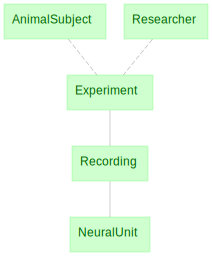

In [15]:
import datajoint as dj

schema = dj.Schema('research_lab')

@schema
class Researcher(dj.Manual):
    definition = """
    researcher_id: int
    ---
    researcher_name: varchar(100)
    email: varchar(100)
    lab_role: varchar(50)
    """

@schema
class AnimalSubject(dj.Manual):
    definition = """
    subject_id: int
    ---
    species: varchar(50)
    date_of_birth: date
    sex: enum('M', 'F', 'Unknown')
    """

@schema
class Experiment(dj.Manual):
    definition = """
    experiment_id: int
    ---
    -> Researcher
    -> AnimalSubject
    experiment_date: date
    description: varchar(255)
    protocol: varchar(100)
    """

@schema
class Recording(dj.Manual):
    definition = """
    -> Experiment
    recording_id: int
    ---
    recording_time: datetime
    file_path: varchar(255)
    recording_quality: enum('excellent', 'good', 'fair', 'poor')
    """

@schema
class NeuralUnit(dj.Manual):
    definition = """
    -> Recording
    unit_id: int
    ---
    spike_rate: float
    receptive_field_size: float
    """

dj.Diagram(schema)


### Populating with Sample Data in DataJoint

Now let's insert the same sample data using DataJoint. Notice how the syntax is Python-native and follows the same hierarchical order:


In [16]:
# Add researchers
Researcher.insert([
    (1, 'Dr. Sarah Chen', 'schen@university.edu', 'Principal Investigator'),
    (2, 'Alex Martinez', 'amartinez@university.edu', 'Postdoc'),
    (3, 'Jamie Park', 'jpark@university.edu', 'Graduate Student'),
])

# Add animal subjects
AnimalSubject.insert([
    dict(subject_id=1, species='Mouse', date_of_birth='2024-01-15', sex='M'),
    dict(subject_id=2, species='Mouse', date_of_birth='2024-01-20', sex='F'),
    dict(subject_id=3, species='Mouse', date_of_birth='2024-02-03', sex='M'),
])

# Add an experiment
Experiment.insert1(dict(
    experiment_id=1,
    researcher_id=2,
    subject_id=1,
    experiment_date='2024-08-15',
    description='Visual cortex recording during grating stimuli',
    protocol='Protocol-V1-001'
))

# Add recordings from that experiment
Recording.insert([
    dict(
        experiment_id=1,
        recording_id=1,
        recording_time='2024-08-15 10:30:00',
        file_path='/data/2024/08/15/rec001.dat',
        recording_quality='excellent'
    ),
    dict(
        experiment_id=1,
        recording_id=2,
        recording_time='2024-08-15 11:45:00',
        file_path='/data/2024/08/15/rec002.dat',
        recording_quality='good'
    ),
])

# Add neural units identified in first recording
NeuralUnit.insert([
    dict(experiment_id=1, recording_id=1, unit_id=1, spike_rate=15.3, receptive_field_size=2.5),
    dict(experiment_id=1, recording_id=1, unit_id=2, spike_rate=8.7, receptive_field_size=3.1),
    dict(experiment_id=1, recording_id=1, unit_id=3, spike_rate=22.4, receptive_field_size=1.8),
])


Notice how DataJoint:
- Uses Python dictionaries for data entry (more readable and type-safe than SQL strings)
- Uses `insert()` for multiple records and `insert1()` for single records
- Still enforces the same foreign key constraints—try inserting an Experiment with a non-existent researcher_id and see what happens!
- The relationship syntax `-> Researcher` automatically creates the foreign key constraint

Let's verify the data was inserted correctly:


### Querying Data in DataJoint

Now let's perform the same queries as the SQL examples. DataJoint provides a Python-native query syntax that is more intuitive and type-safe:


#### Basic SELECT Queries

These match the SQL SELECT examples:


In [13]:
# Get all researchers (equivalent to SELECT * FROM Researcher)
Researcher()

researcher_id,name,email,lab_role
1,Dr. Sarah Chen,schen@university.edu,Principal Investigator
2,Alex Martinez,amartinez@university.edu,Postdoc
3,Jamie Park,jpark@university.edu,Graduate Student


In [17]:
# Get specific attributes (equivalent to SELECT name, email FROM Researcher WHERE lab_role = 'Graduate Student')
(Researcher & {'lab_role': 'Graduate Student'}).proj('researcher_name', 'email')

researcher_id,researcher_name,email
3,Jamie Park,jpark@university.edu


In [19]:

# Count neural units per recording (equivalent to SELECT experiment_id, recording_id, COUNT(*) as unit_count 
#                                   FROM NeuralUnit GROUP BY experiment_id, recording_id)
Recording.aggr(NeuralUnit, n='count(*)')

experiment_id,recording_id,n calculated attribute
1,1,3


In [23]:
# Get average spike rate (equivalent to SELECT AVG(spike_rate), STD(spike_rate) FROM NeuralUnit)
dj.U().aggr(NeuralUnit, avg_spike_rate='avg(spike_rate)', std_dev='std(spike_rate)' )

avg_spike_rate calculated attribute,std_dev calculated attribute
15.466666539510092,5.594242990034591


#### Joining Tables in DataJoint

The power of relational queries comes through naturally in DataJoint using Python's join operator `*`:


In [ ]:
# Which researcher conducted each experiment?
# Equivalent to: SELECT e.experiment_id, e.experiment_date, r.name as researcher_name
#               FROM Experiment e JOIN Researcher r ON e.researcher_id = r.researcher_id

(Experiment * Researcher).proj('experiment_date', 'researcher_name')

experiment_id,researcher_id,experiment_date,researcher_name
1,2,2024-08-15,Alex Martinez


In [30]:
# Full experiment details including subject
# Equivalent to: SELECT experiment_id, experiment_date, researcher_name, species, sex, description
#               FROM Experiment 
#               JOIN Researcher USING(researcher_id)
#               JOIN AnimalSubject (subject_id)
# DataJoint automatically follows both foreign key relationships

(Experiment * Researcher * AnimalSubject).proj(
    'experiment_date', 'researcher_name', 'species', 'sex', 'description')


experiment_id,researcher_id,subject_id,experiment_date,description,researcher_name,species,sex
1,2,1,2024-08-15,Visual cortex recording during grating stimuli,Alex Martinez,Mouse,M


In [ ]:

# Count recordings per researcher
# Equivalent to: SELECT researcher_id, researcher_name, COUNT(*) as num_recordings
#               FROM Researcher
#               JOIN Experiment USING (researcher_id)
#               JOIN Recording USING (eexperiment_id)
#               GROUP BY researcher_id

Researcher.aggr(Experiment * Recording, num_recordings='count(*)')


researcher_id,num_recordings calculated attribute
2,2


Notice how DataJoint queries:
- Use Python operators (`*` for joins, `&` for restrictions) instead of SQL keywords
- Support method chaining for complex queries
- Provide `fetch('attribute')` for getting specific fields
- Support `format='frame'` to return pandas DataFrames for analysis
- Automatically follow foreign key relationships defined in the schema

The queries above demonstrate that DataJoint maintains the full power of relational queries while being more Pythonic and integrated with the scientific Python ecosystem.


**The Problems:**

1. **No Automatic Tracking**: The database doesn't know that NeuralUnit depends computationally on Recording. The foreign key establishes a relationship but doesn't capture the *computational* dependency.

2. **Manual Propagation**: We must manually figure out what needs updating and write UPDATE statements. For complex pipelines with many stages, this becomes error-prone.

3. **Lost Provenance**: After the UPDATE, there's no record that these spike rates were corrected. Someone looking at the data later won't know these values were modified.

4. **Silent Staleness**: If we forget to update some dependent data, the database won't warn us. We can have internally consistent but scientifically invalid data.

5. **No Recomputation Code**: The logic for computing spike rates from recordings exists somewhere in Python/MATLAB scripts, but it's separate from the database. Recomputing requires finding and running the right scripts.


### The Missing Link: Computational Dependencies

Traditional databases understand:
- "This NeuralUnit **belongs to** this Recording" (referential integrity)

But not:
- "This NeuralUnit was **computed from** this Recording" (computational dependency)
- "When Recording changes, NeuralUnit must be **recomputed**" (workflow validity)
- "Use **this code** to compute NeuralUnit from Recording" (executable specification)

This gap between data relationships and computational relationships is what DataJoint addresses.


## What's Missing for Scientific Workflows

Let's enumerate what traditional relational databases lack for scientific computing:


### 1. Temporal Semantics

The database has no built-in notion of "when" or "how" data was created:
- Was this NeuralUnit entered manually or computed?
- When was it created relative to its source data?
- What version of analysis code produced it?

Traditional databases treat all data equally—a measurement entered by a researcher and a result computed by an algorithm have the same status.


### 2. Computational Dependencies

Foreign keys enforce **existence** but not **computational relationships**:
- `FOREIGN KEY (recording_id)` ensures the recording exists
- But it doesn't capture that spike rates are **derived from** that recording
- Or that they must be **recomputed** if the recording changes

This means the database can maintain referential integrity while containing scientifically invalid results.


### 3. Automatic Execution

There's no mechanism for "compute this when inputs are ready":
- Adding a new Recording doesn't trigger NeuralUnit computation
- The database just stores data; external scripts perform computations
- Coordinating this requires manual workflow management


### 4. Immutability and Provenance

UPDATE is equally privileged as INSERT, enabling silent invalidation:
- You can modify a derived result without recomputing it
- No automatic tracking of computation history
- Provenance must be implemented separately (if at all)


### 5. Workflow Visibility

The database schema shows **structure** but not **process**:
- Looking at table definitions, you can't tell what's input vs. derived
- Dependencies exist implicitly in application code, not in the schema
- New team members must read external documentation to understand the pipeline


## The Path Forward

These limitations aren't failures of relational databases—they're working exactly as designed. Traditional RDBMS were built for transactional workloads (banking, inventory, reservations) where UPDATE is a primary operation and data provenance isn't critical.

Scientific workflows have different requirements:
- **Data flows through transformations**, from raw inputs to analyzed results
- **Provenance is crucial**: "how was this result computed?"
- **Reproducibility demands**: rerun the pipeline, get the same results
- **Collaboration requires**: clear workflow specification that new team members can understand

**DataJoint extends relational theory to meet these needs.** It preserves all the benefits of relational databases—mathematical rigor, declarative queries, data integrity—while adding workflow semantics that make the database **workflow-aware**.

The next chapter introduces DataJoint's Relational Workflow Model, showing how your database schema becomes an executable specification of your scientific pipeline.


## Exercises


### 1. Design Practice

Design an ER diagram for a different scientific domain (choose one):
- **Genomics**: Samples → Sequencing runs → Variants → Annotations
- **Climate science**: Weather stations → Measurements → Aggregated statistics → Climate indicators
- **Particle physics**: Detectors → Events → Tracks → Particle identifications

Identify: entities, relationships, primary keys, foreign keys.


### 2. Query Practice

Using our research lab database, write SQL queries to:
1. Find all experiments conducted in August 2024
2. Calculate the average spike rate per experiment (joining through Recording)
3. List researchers who haven't conducted any experiments yet
4. Find the subject that participated in the most experiments


In [ ]:
-- Write your queries here

-- 1. Find all experiments conducted in August 2024


-- 2. Calculate the average spike rate per experiment


-- 3. List researchers who haven't conducted any experiments yet


-- 4. Find the subject that participated in the most experiments


### 3. Workflow Analysis

Consider adding a new table `SpikeAnalysis` that computes statistics from `NeuralUnit`:


In [ ]:
CREATE TABLE SpikeAnalysis (
    analysis_id INT PRIMARY KEY AUTO_INCREMENT,
    recording_id INT NOT NULL,
    mean_spike_rate FLOAT,
    spike_rate_std FLOAT,
    num_units INT,
    FOREIGN KEY (recording_id) REFERENCES Recording(recording_id)
);


Questions:
1. If you UPDATE a spike_rate in NeuralUnit, should SpikeAnalysis change? How would you ensure this?
2. If you DELETE a Recording, what happens to SpikeAnalysis? Should CASCADE be used?
3. How would you track *when* each analysis was computed and *which code version* produced it?


### 4. Provenance Challenge

Design a solution for tracking data provenance in traditional SQL:
- Which analyses depend on which recordings?
- When was each result computed?
- What parameters were used?
- How would you implement "recompute all results from this recording"?

Compare your solution's complexity to what you know DataJoint provides.


### 5. Reflection

Think about your own research data:
1. What entities and relationships exist?
2. What data is manually entered vs. automatically computed?
3. What happens when you discover an error in upstream data?
4. How do you currently track "what needs recomputing"?

These questions will help you appreciate what DataJoint provides when we introduce it in the next chapter.
